# 5.4 Multi-model experiments

- Experiments: Create Pseudoproxies from different models and see how others are able to reconstruct them (temperature).
                - Main hypothesis: multi-model ensembles are better than separate models
                - Pseudoproxies? Either pure d18O, or modified by psm (with fractionation/filter??, wie schlecht wird es?)

- First Ideas: 
    - Everything is debiased
    - Still, the Pseudoproxies are created with the full psm, including fractionation but no filter. -> the PPEs with SNR=0.5 and filter resulted in very weak results (especially for icecores)
    - i originally thought about option filter and no filter, in both prior and pseudoproxies, but making the pseudoproxies with snr=0.5 and the filter is just bad.

- (Inspiration: Parsons 2021, multi model)
- Swarm plot: x-axes target model, y-axis correlation or rmse
        - RMSE in temperature is better because I don't need to go from 0 to 1 as for correlation. CE also ok

Appendix:
    - Plots for all variables (3x2, (Tsurf, Prec, d18O), (RMSE,Reduction of error  ))

**Experiments:**
- full debiasing
- ppe: snr 0.5 (ohne filters)

**Data:** 
- upsample paths
- 


In [1]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import xskillscore as xss
import pandas as pd
import evaluation

import copy

%load_ext autoreload
%autoreload 2

In [2]:
#paths to all models (downsampled to Echam resolution)
multi_prior_ds={
    'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       },
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc',
       },
}

#upsampled multiprior
multi_prior_up={
    'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       },
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/upsampled/GISS_slp_850_1849.nc',
       },
}

In [3]:
#CONFIG DICTIONARY (NEW)

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales
cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'reconstruct':['tsurf'],
#'reconstruct':['tsurf','d18O','prec'],
'basepath':'/home/mchoblet/paleoda/', #dont forget last slash
'output_folder':'thesis_5_4', #in cwd
'output_file':'Echam_realistic_PPE_snr1',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':False, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']],
'how_many': None, #use all 108/109 locations, that's easier.
'only_regional_proxies':False,
'regional_bounds':False,
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1,0.1], #irrelevant for PPE
#irrelevant for PPE
'time_scales': ['median','median'],
'proxy_time':['0851','1849'],
'time': ['0851','1849'], #das ist in allen modellen drin
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,

'psm':['speleo','icecore'], 
'interpol':None, #None/'dw'
'var_psm': ['d18O','d18O'] ,
'speleo':{
    'weighting': 'inf',#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},

###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': True,
    'SNR': [0.5,0.5], #signal to noise variance ratio
    'noise_bf_filt':True,
    'noise_type': 'w', #'w'/'r'
     #'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1],[1]], 
    'source': 'external', #internal/external
    'other_model': 
    {'vp':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
    'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
    'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
    'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','p_bootstrap','eff_p_value','CE','RE','RMSE'],#'RMSE','RMSPE','MAE','MAPE'],
    'psm' : {
    'speleo': {'weighting':'inf', 'height': False, 'fractionation':True, 'fractionation_temp': 'regular', 'filter': False, 't_time': 2.5,},
    'icecore':{'weighting':'prec', 'height': False, 'filter': False,},
    },
},

###KALMAN-FILTER
'time': ['0851','1849'], #covered by all models
'nens':100, #ensemble members
'reps':1, #Monte Carlo
'full_fields': True, 
'proxy_frac': None,
'extra_assi': 
    {
        'globalmean': ['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': None, #['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #'BG+HX', #/ 'HX'
'anomaly_time': None, #['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

# Pseudoproxies with SNR=0.5, Precipitation and Infiltration weighted, fractionation

- PSM for prior uses the same
- use downsampled paths


In [4]:
"""
Paths is the multi-prior variable (where the second one is orography just in case). Hence treat first element of paths, paths[0] as the dict with paths.
"""
cfg_exp=cfg.copy()
paths=multi_prior_ds

cfg['speleo']={'weighting': 'inf', 'height': False,
 'fractionation': True,
 'fractionation_temp': 'regular',
 'filter': False,
 't_time': 2.5}
cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

cfg['noise_bf_filt']=True
cfg['ppe']['psm']['speleo']=cfg['speleo']
cfg['ppe']['psm']['icecore']=cfg['icecore']
cfg['output_folder']='thesis_5_4'
cfg['ppe']['SNR']=[0.5,0.5]
cfg['reps']=10

#loop over proxy origin
for i1,target in enumerate(paths.keys()):
    #pseudoproxy source
    cfg_exp=copy.deepcopy(cfg)
    cfg_exp['multi_model_prior']=None
    cfg_exp['ppe']['other_model']['vp']=paths[target]

    if target=='iHadCM3':
        cfg_exp['check_nan']=True
    else:
        cfg_exp['check_nan']=False

    #loop over priors 
    for i2,prior in enumerate(paths.keys()):
        if prior=='iHadCM3':
            cfg_exp['check_nan']=True
        else:
            cfg_exp['check_nan']=False
        
        cfg_exp['vp']=paths[prior]
        cfg_exp['output_file']=target+'_target_'+prior+'_prior'
        wrapper.paleoda_wrapper(cfg_exp)    

    cfg_exp['check_nan']=True
    #use multi-model_ensemble
    cfg_exp['multi_model_prior']=paths
    cfg_exp['output_file']=str(i1)+'_PP_'+'mme'+'_prior'
    wrapper.paleoda_wrapper(cfg_exp)

    #mme-nogiss
    copied_paths=copy.deepcopy(paths)
    #delete current proxy origin
    del copied_paths['GISS']
    cfg_exp['multi_model_prior']=copied_paths
    cfg_exp['output_file']=str(i1)+'_PP_'+'mme'+'_prior'
    wrapper.paleoda_wrapper(cfg_exp)
    
    #use multi-model_ensemble (leave one out)
    copied_paths=copy.deepcopy(paths)
    #delete current proxy origin
    del copied_paths[target]

    cfg_exp['multi_model_prior']=copied_paths
    cfg_exp['output_file']=target+'_target_'+'mme_loo'+'_prior'
    wrapper.paleoda_wrapper(cfg_exp)
    
    #mme (leave one out, no giss
    copied_paths=copy.deepcopy(paths)
    #delete current proxy origin
    del copied_paths[target]
    del copied_paths['GISS']

    cfg_exp['multi_model_prior']=copied_paths
    cfg_exp['output_file']=target+'_target_'+'mme_loo_nogiss'+'_prior'
    wrapper.paleoda_wrapper(cfg_exp)
    

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01

KeyboardInterrupt: 

# The same with less noise and pseudoproxies that are created with the filters

In [ ]:
def triple_test(cfg0,prior):
    
    cfg0['speleo']['weighting']=None
    cfg0['speleo']['fractionation']=False
    cfg0['speleo']['filter']=False
    cfg0['icecore']['weighting']=None
    cfg0['icecore']['filter']= False
    
    cfg0['output_file']=target+'_target_'+prior+'_prior_nopsm'
    wrapper.paleoda_wrapper(cfg0)
    
    cfg0['speleo']['weighting']='inf'
    cfg0['speleo']['fractionation']=True
    cfg0['speleo']['filter']=False
    cfg0['icecore']['weighting']='prec'
    cfg0['icecore']['filter']= False
    
    cfg0['output_file']=target+'_target_'+prior+'_prior_psmlight'
    wrapper.paleoda_wrapper(cfg0)
    
    cfg0['speleo']['weighting']='inf'
    cfg0['speleo']['fractionation']=True
    cfg0['speleo']['filter']=True
    cfg0['icecore']['weighting']='prec'
    cfg0['icecore']['filter']= True
    
    cfg0['output_file']=target+'_target_'+prior+'_prior_psmfull'
    wrapper.paleoda_wrapper(cfg0)

In [ ]:
cfg['nens']=50

In [ ]:
"""
Paths is the multi-prior variable (where the second one is orography just in case). Hence treat first element of paths, paths[0] as the dict with paths.
"""
cfg_exp=cfg.copy()
paths=multi_prior_ds

cfg['speleo']={'weighting': 'inf', 'height': False,
 'fractionation': True,
 'fractionation_temp': 'regular',
 'filter': False,
 't_time': 2.5}
cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}

cfg['anomaly']='BG+HX'
cfg['noise_bf_filt']=True
cfg['ppe']['psm']['speleo']=cfg['speleo']
cfg['ppe']['psm']['icecore']=cfg['icecore']

cfg['output_folder']='thesis_5_4_filter'
cfg['ppe']['SNR']=[5,5]

#loop over proxy origin
for i1,target in enumerate(paths.keys()):
    #pseudoproxy source
    cfg_exp=copy.deepcopy(cfg)
    cfg_exp['multi_model_prior']=None
    cfg_exp['ppe']['other_model']['vp']=paths[target]

    if target=='iHadCM3':
        cfg_exp['check_nan']=True
    else:
        cfg_exp['check_nan']=False

    #loop over priors 
    for i2,prior in enumerate(paths.keys()):
        if prior=='iHadCM3':
            cfg_exp['check_nan']=True
        else:
            cfg_exp['check_nan']=False    
        cfg_exp['vp']=paths[prior]
        #cfg_exp['output_file']=target+'_target_'+prior+'_prior'
        #wrapper.paleoda_wrapper(cfg_exp)
        triple_test(cfg_exp,prior)
        
    cfg['check_nan']=True
    #use multi-model_ensemble
    cfg_exp['multi_model_prior']=paths
    #cfg_exp['output_file']=str(i1)+'_PP_'+'mme'+'_prior'
    #wrapper.paleoda_wrapper(cfg_exp)
    triple_test(cfg_exp,'mme')

    #mme-nogiss
    copied_paths=copy.deepcopy(paths)
    #delete current proxy origin
    del copied_paths['GISS']
    cfg_exp['multi_model_prior']=copied_paths
    #cfg_exp['output_file']=str(i1)+'_PP_'+'mme'+'_prior'
    #wrapper.paleoda_wrapper(cfg_exp)
    triple_test(cfg_exp,'mme_nogiss')
    
    #use multi-model_ensemble (leave one out)
    copied_paths=copy.deepcopy(paths)
    #delete current proxy origin
    del copied_paths[target]

    cfg_exp['multi_model_prior']=copied_paths
    #cfg_exp['output_file']=target+'_target_'+'mme_loo'+'_prior'
    #wrapper.paleoda_wrapper(cfg_exp)
    triple_test(cfg_exp,'mme_loo')
    
    #mme (leave one out, no giss
    copied_paths=copy.deepcopy(paths)
    #delete current proxy origin
    del copied_paths[target]
    del copied_paths['GISS']

    cfg_exp['multi_model_prior']=copied_paths
    #cfg_exp['output_file']=target+'_target_'+'mme_loo_nogiss'+'_prior'
    #wrapper.paleoda_wrapper(cfg_exp)
    triple_test(cfg_exp,'mme_loo_nogiss')
    

In [5]:
def anomaly(ds,start='0851',end='1849'):
    """
    start='1850'
    end='1900'
    """
    ds=ds-ds.sel(time=slice(start,end)).mean('time')
    return ds

models_tsurf={'isoGSM':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
'iCESM':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
'Echam':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'GISS':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc'}

model_data={}
for m,p in models_tsurf.items():
    data=dataloader.annual_mean(xr.open_dataset(p)['tsurf'],check_nan=True).sel(time=slice('0851','1849'))
    data=utils.globalmean(anomaly(data))
    model_data[m]=data
    
    #plt.plot(data,label=m)
    #model_data.append(data)
    
#model_mean_temp_glb=np.median(model_data,axis=0)
#model_std_temp_glb=np.std(model_data,axis=0)


Checking prior for nans
Checking prior for nans
Checking prior for nans
Checking prior for nans
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year


In [11]:
#Code for plotting
#create dataframe and then plot it as a swarm plot
#the key to have the many-files-plotted is that the file-name has a consistent structure

def multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased/',
                          models=['iCESM','Echam','GISS','iHadCM3','isoGSM'],
                          priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme_loo'],
                          priors2=['iCESM','Echam','GISS','iHadCM3','isoGSM','MME',],
                         metric='tsurf_Corr'):
        """
        Returns all global-metrics in a Dataframe form.
        Basepath with / at the end.
        """
        
        #create Dataframe Columns
        prior_col=np.concatenate(np.repeat([priors2],len(models),axis=0))
        models_col=np.repeat(models,len(priors2))
        #loop over models and compute the metric
        results=[]
        for mod in models:
            for p in priors:
                #string=basepath+mod+'_target_'+p+'_prior.nc'
                string=basepath+mod+'_target_'+p+'_prior_0.nc'
                data=xr.open_dataset(string)[metric]
                data=replace_outliers(data)
                results.append(utils.globalmean(data).values.tolist())
        all_data={
            'metric':results,
            'model': models_col,
            'prior':prior_col,}
        df=pd.DataFrame(all_data)
        return df

def multi_model_dataframe_gmt(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased/',
                          models=['iCESM','Echam','GISS','iHadCM3','isoGSM'],
                          priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme_loo'],
                          priors2=['iCESM','Echam','GISS','iHadCM3','isoGSM','MME',],
                          original=model_data,
                         metric='tsurf_Corr'):
        """
        Returns all global-metrics in a Dataframe form.
        Basepath with / at the end.
        """
        import copy
        
 
        
        #create Dataframe Columns
        prior_col=np.concatenate(np.repeat([priors2],len(models),axis=0))
        models_col=np.repeat(models,len(priors2))

        #loop over models and compute the metric
        results=[]
        for mod in models:
            truth=original[mod]
            for p in priors:
                #string=basepath+mod+'_target_'+p+'_prior.nc'
                string=basepath+mod+'_target_'+p+'_prior_0.nc'
                data=xr.open_dataset(string)['gm_tsurf']
                #data=replace_outliers(data)
                if metric=='Corr':
                    results.append(evaluation.Corr(truth,data).values.tolist())
                elif metric=='RE':
                    if p!='mme_loo':
                        results.append(evaluation.RE(truth,data,original[p]).values.tolist())
                    #exceptional mean from mme (without target!)
                    else:
                       
                        priors2=copy.deepcopy(models)
                        #del priors2[mod]
                        priors2.remove(mod)
                        array=[]
                        for p2 in priors2:
                            array.append(original[p2].values)
                        uninformed2=np.mean(array,axis=0)
                        uninformed=truth.copy(deep=True)
                        uninformed.data=uninformed2
                        #import pdb
                        #pdb.set_trace()
                        results.append(evaluation.RE(truth,data,uninformed).values.tolist())
                elif metric=='RMSE':
                    results.append(evaluation.RMSE(truth,data).values.tolist())
        
                #results.append(utils.globalmean(data).values.tolist())
        all_data={
            'metric':results,
            'model': models_col,
            'prior':prior_col,}
        df=pd.DataFrame(all_data)
        return df
    
    
def replace_outliers(data):

    # calculate percentile 
    #threshold = data.quantile(0.001)
    threshold=-4
    
    # find outliers and replace them with max among remaining values 
    mask = data.where(data >= threshold)
    min_value = mask.min().values
     # .where replace outliers with nan
    mask = mask.fillna(min_value)
    #print(mask)
    data= mask

    return data

    
def swarm_plot(df, name='',models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title=''):
    
    sns.set_palette("colorblind")

    si = 15
    fig = plt.figure(figsize=(12,8))
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="prior",size=si,marker='o',)

    handles, labels = ax.get_legend_handles_labels()
    plt.xticks(np.arange(len(models)),models)
    plt.xlabel('Models for Pseudoproxies (Truth)',fontsize=20)
    plt.xticks(rotation=45,ha="right",fontsize=16)
    plt.ylabel(name,fontsize=20)
    plt.yticks(fontsize=16)
    plt.ylim(0,0.6)
    l = plt.legend(handles, labels, loc='upper right',frameon=True,fontsize=14)
    plt.title(title,fontsize=20)
    plt.grid()

    if savename is not None:
        strg='/home/mchoblet/paleoda/results/plots/'+savename+'.pdf'
        plt.savefig(strg, format='pdf',bbox_inches='tight')

    

In [12]:
#series=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_4/isoGSM_target_isoGSM_prior.nc')
#series=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_4/isoGSM_target_Echam_prior.nc')
series=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_4/isoGSM_target_mme_loo_prior.nc')
print(evaluation.Corr(series['gm_tsurf'],model_data['isoGSM']))
print(evaluation.RE(model_data['isoGSM'],series['gm_tsurf'],model_data['isoGSM']))
#print(evaluation.CE(model_data['isoGSM'],series['gm_tsurf']))
print(evaluation.RMSE(series['gm_tsurf'],model_data['isoGSM']))

<xarray.DataArray ()>
array(0.43616559)
<xarray.DataArray ()>
array(0.18968959)
<xarray.DataArray ()>
array(0.17877739)


In [168]:
import matplotlib as mpl
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 

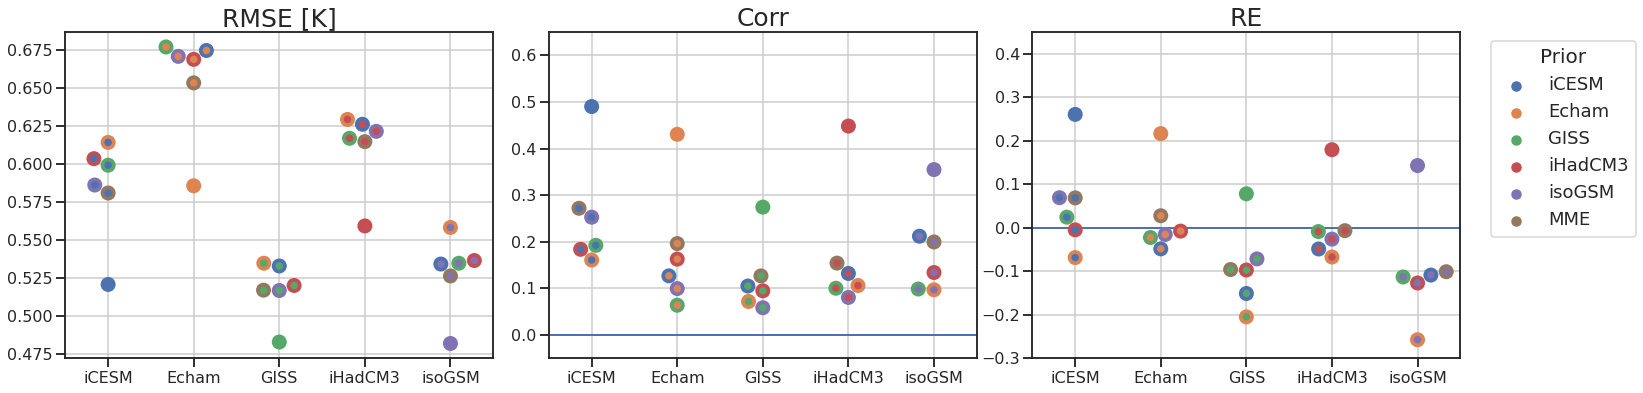

In [75]:

si = 15
fig, axs = plt.subplots(1,3,figsize=(25,6))
models=['iCESM','Echam','GISS','iHadCM3','isoGSM']
sns.color_palette("colorblind",6)

#titles=['SNR 5 (single timescale)','SNR 1 (single timescale)','SNR 5 (multi timescale)','SNR 1 (multi timescale)']
ylabels=['RMSE','Corr','CE']

savename=None
mets=['RMSE','Corr','RE',]

basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_4/'

for i in range(3):
    sns.set(style='ticks', context='talk')
    #title=titles[i]
    ax1=axs.flatten()[i]
    name='Correlation'
    if i==2:
        legend='auto'
    else:
        legend=False
    df=multi_model_dataframe(basepath=basepath,metric=('tsurf_'+mets[i]))
    #import pdb
    #pdb.set_trace()
    
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="prior",size=si,marker='o',ax=ax1,legend=legend)
    
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="model",size=si,marker='.',ax=ax1,legend=False)
   
    ax1.set_xticks(np.arange(len(models)),models,fontsize=16)
    ax1.set_xlabel('',fontsize=20)
    ax1.set_ylabel('',fontsize=20)
    ax1.set_title(mets[i],fontsize=25)
    ax1.tick_params(axis='y', labelsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    #ax1.set_ylim(0,1)
    #ax1.set_title(title,fontsize=24)
    
    if i==0:
        ax1.set_title('RMSE [K]',fontsize=25)
    
    if i==1:
        ax1.axhline(0,lw=2)
        ax1.set_ylim(-0.05,0.65)
    if i==2:
        ax1.set_ylim(-0.3,0.45)
        ax1.axhline(0,lw=2)
        handles, labels = ax.get_legend_handles_labels()
        l = ax1.legend(handles, labels, frameon=True,fontsize=18,bbox_to_anchor=(1.05, 1),title='Prior',title_fontsize=20)
    ax1.grid()
    #ax1.set_yim(-0.2,1)
    
plt.subplots_adjust(wspace=0.13)

In [76]:
fig.savefig('/home/mchoblet/plots_thesis/5_4/mme.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

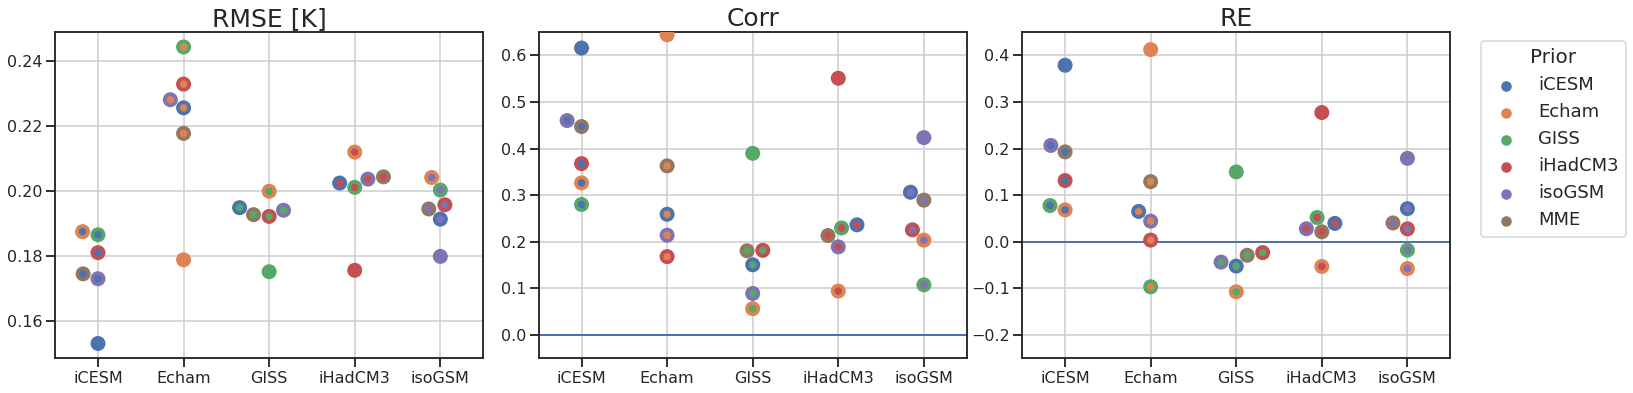

In [77]:
### THE SAME FOR GMT (!)

sns.color_palette("colorblind",6)
si = 15
fig2, axs = plt.subplots(1,3,figsize=(25,6))
models=['iCESM','Echam','GISS','iHadCM3','isoGSM']

#titles=['SNR 5 (single timescale)','SNR 1 (single timescale)','SNR 5 (multi timescale)','SNR 1 (multi timescale)']
ylabels=['RMSE','Corr','RE']

savename=None
mets=['RMSE','Corr','RE']

basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_4/'

for i in range(3):
    #title=titles[i]
    ax1=axs.flatten()[i]
    name='Correlation'
    if i==2:
        legend='auto'
    else:
        legend=False
    df=multi_model_dataframe_gmt(basepath=basepath,metric=(mets[i]),original=model_data)
    #import pdb
    #pdb.set_trace()
    
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="prior",size=si,marker='o',ax=ax1,legend=legend)
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="model",size=si,marker='.',ax=ax1,legend=False)
    handles, labels = ax.get_legend_handles_labels()
    ax1.set_xticks(np.arange(len(models)),models,fontsize=16)
    ax1.set_xlabel('',fontsize=20)
    ax1.set_ylabel('',fontsize=20)
    ax1.set_title(mets[i],fontsize=25)
    ax1.tick_params(axis='y', labelsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    #ax1.set_ylim(0,1)
    #ax1.set_title(title,fontsize=24)
    
    if i==0:
        ax1.set_title('RMSE [K]',fontsize=25)
    
    if i==1:
        ax1.axhline(0,lw=2)
        ax1.set_ylim(-0.05,0.65)
    
    if i==2:
        ax1.set_ylim(-0.25,0.45)
        ax1.axhline(0,lw=2)
        l = ax1.legend(handles, labels, frameon=True,fontsize=18,bbox_to_anchor=(1.05, 1),title='Prior',title_fontsize=20)
    ax1.grid()
    #ax1.set_ylim(-0.2,1)
plt.subplots_adjust(wspace=0.13)

In [78]:
fig2.savefig('/home/mchoblet/plots_thesis/5_4/mme_gmt.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

In [79]:
def RE(true,recon,prior):
    """
    Reduction of error (as in Bhend 2012) compared to uninformed prior mean
    prior-mean does not have the time dimension, xarray automatically does the broadcasting correctl
    """
    den=np.square(true-recon).sum('time')
    nom=np.square(prior.mean('time')-true).sum('time')
    return 1-den/nom


In [16]:
xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_5_4/iCESM_target_Echam_prior.nc')['tsurf_RE']


<xarray.DataArray 'tsurf_RE' (lat: 48, lon: 96)>
array([[0.136049, 0.133904, 0.133157, ..., 0.141882, 0.140268, 0.13833 ],
       [0.18094 , 0.180395, 0.178401, ..., 0.18645 , 0.185257, 0.183431],
       [0.155486, 0.135451, 0.125942, ..., 0.188666, 0.19119 , 0.174577],
       ...,
       [0.314415, 0.324835, 0.323181, ..., 0.285916, 0.301789, 0.309448],
       [0.295012, 0.303287, 0.304678, ..., 0.27488 , 0.284792, 0.288808],
       [0.315823, 0.318896, 0.320203, ..., 0.3019  , 0.306293, 0.314391]])
Coordinates:
  * lat      (lat) float64 87.16 83.48 79.78 76.07 ... -79.78 -83.48 -87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

## Effect des Filters nach noise draufsetzen

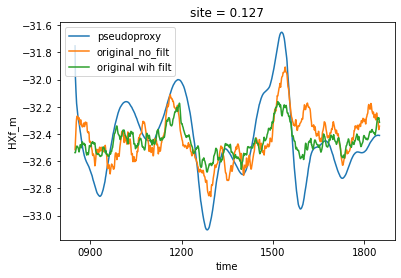

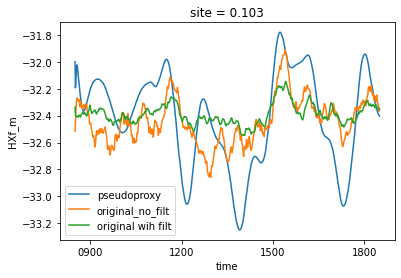

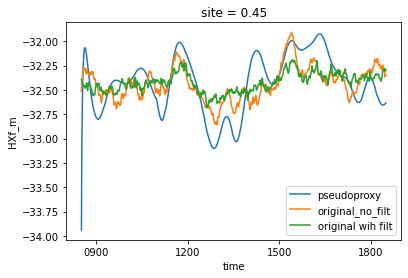

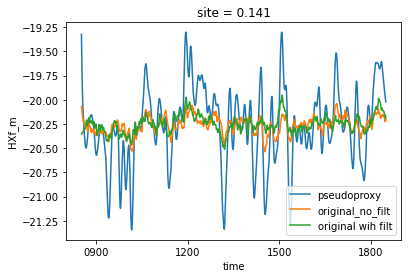

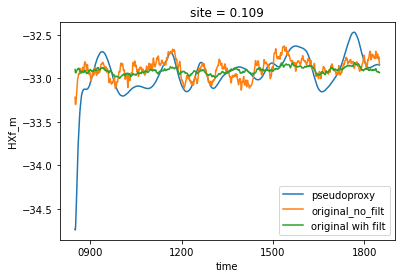

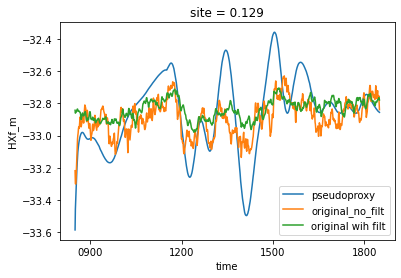

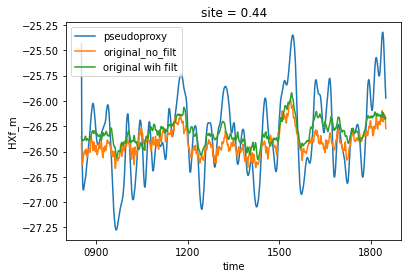

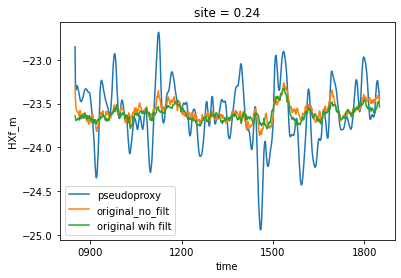

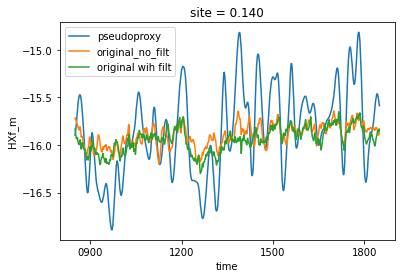

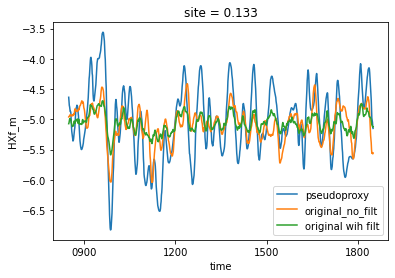

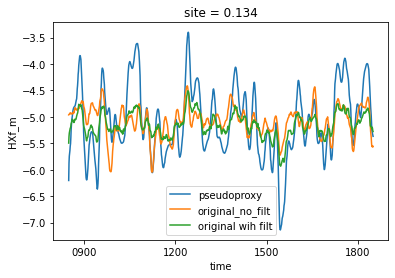

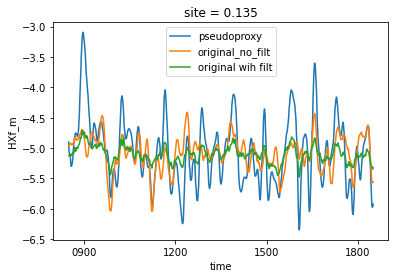

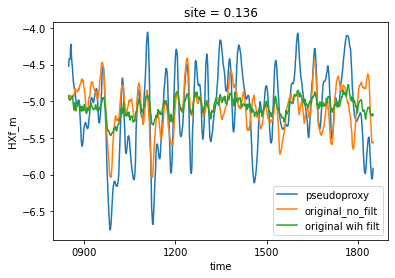

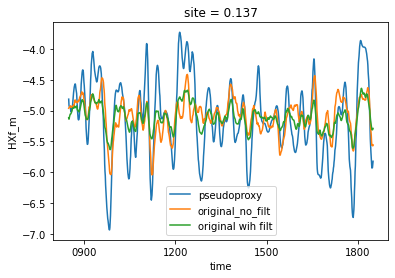

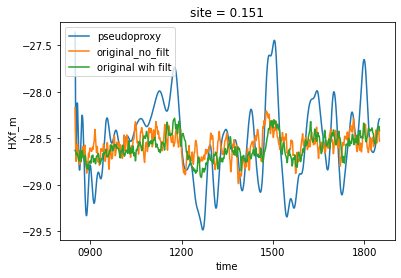

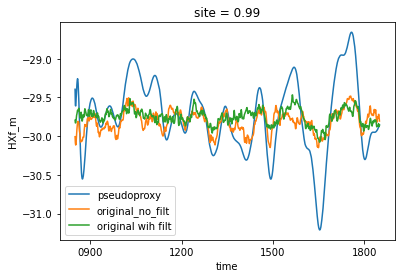

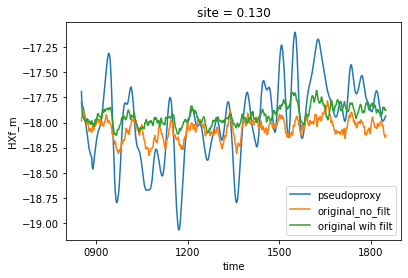

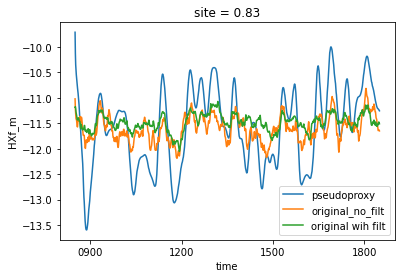

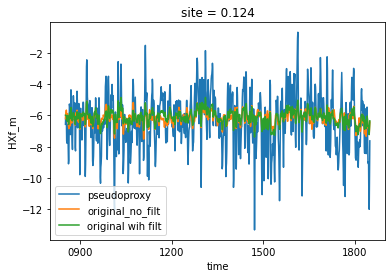

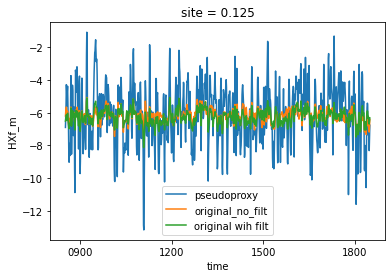

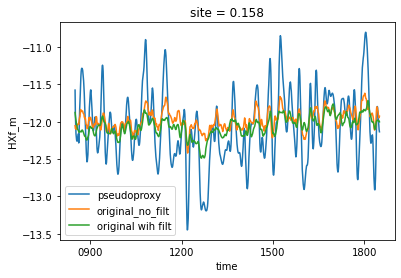

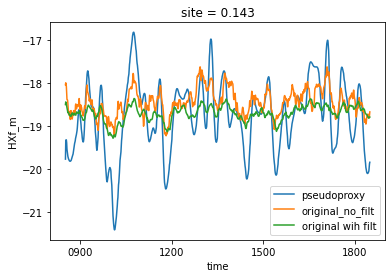

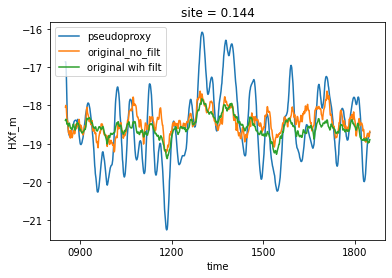

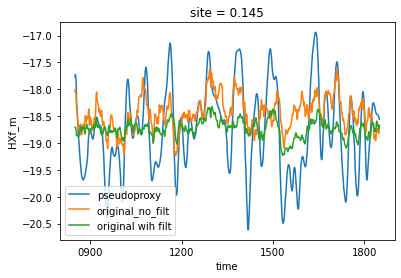

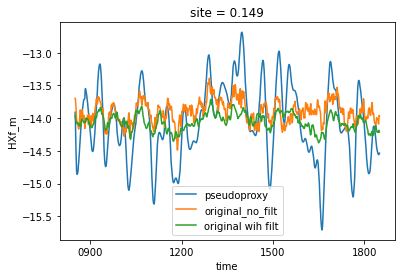

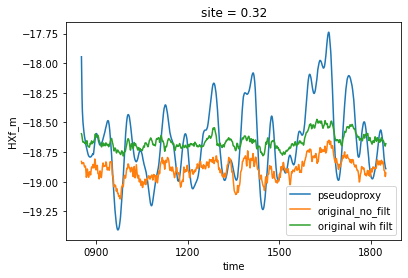

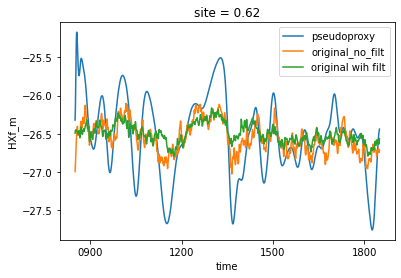

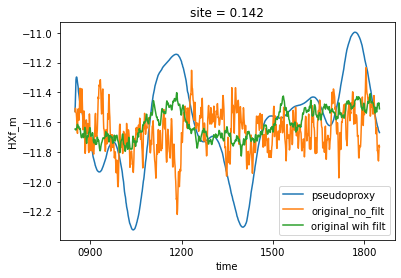

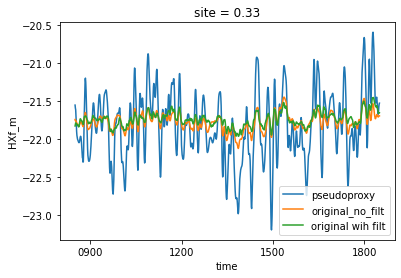

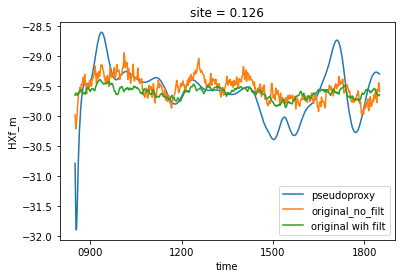

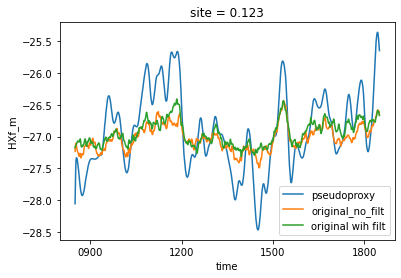

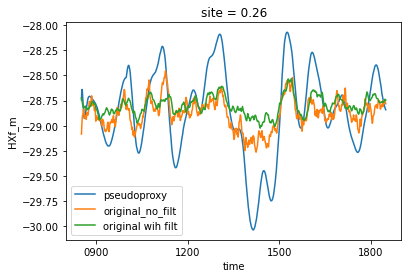

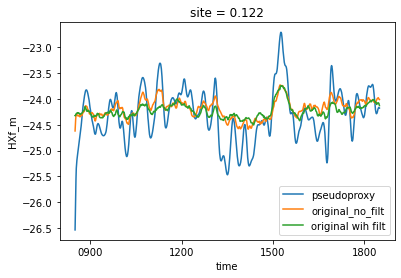

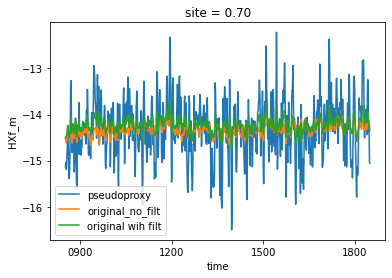

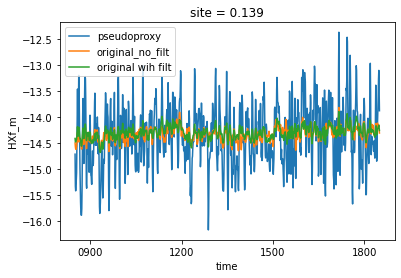

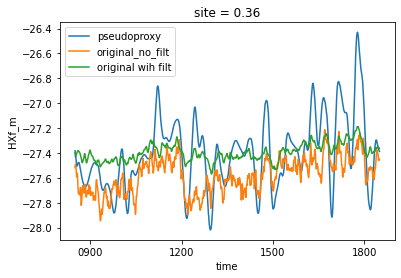

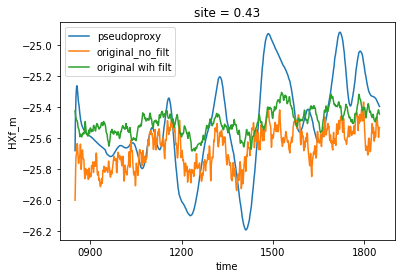

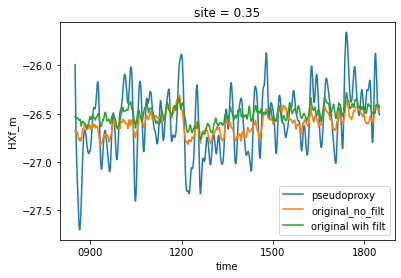

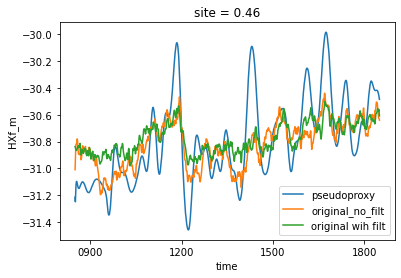

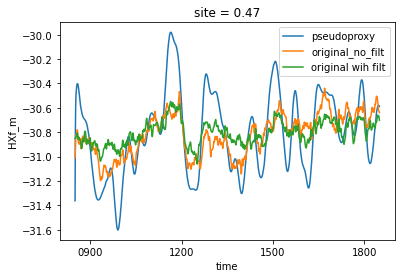

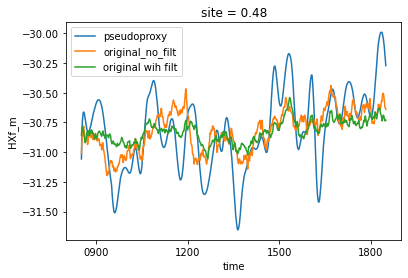

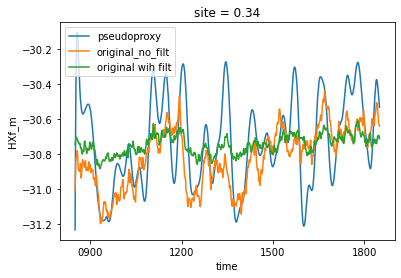

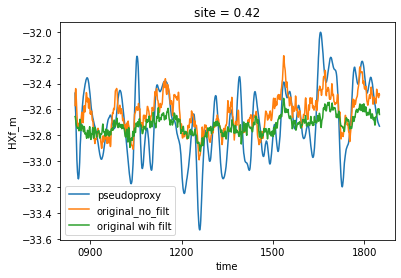

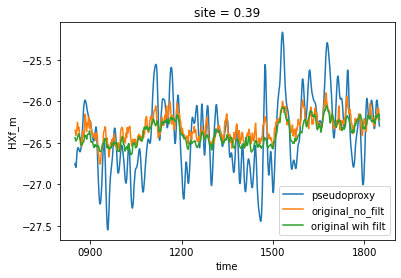

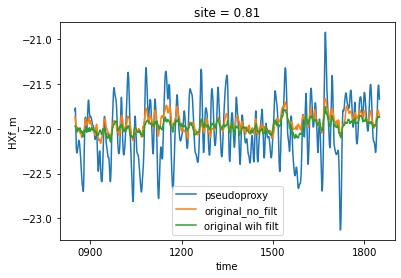

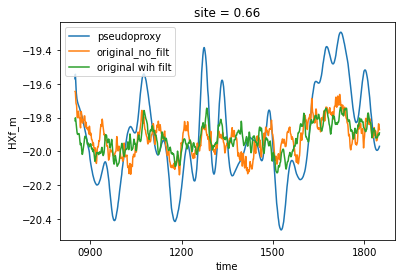

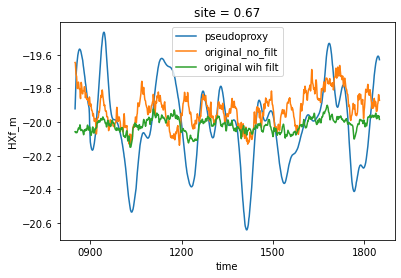

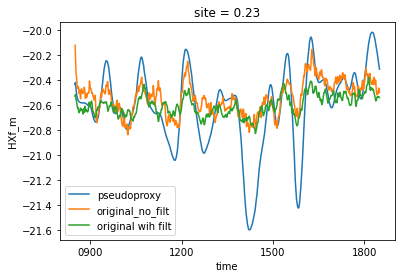

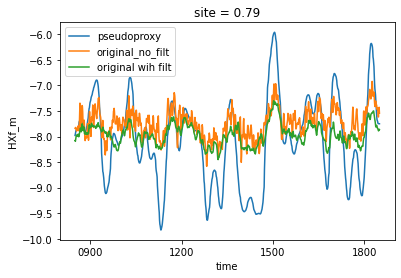

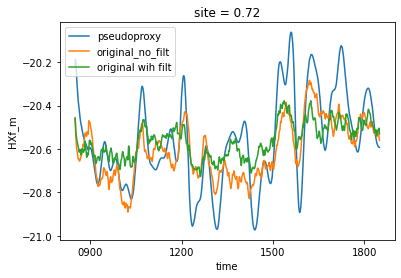

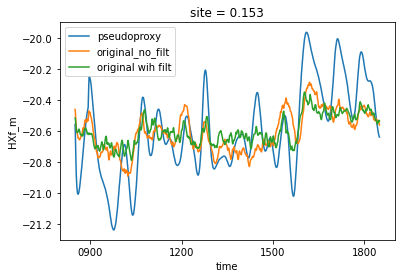

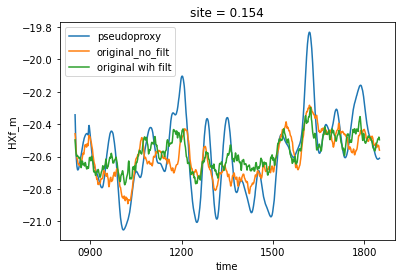

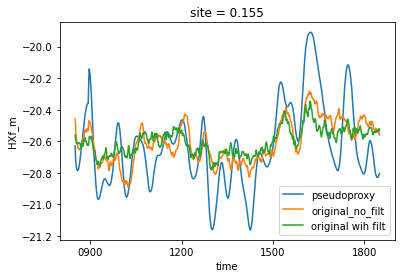

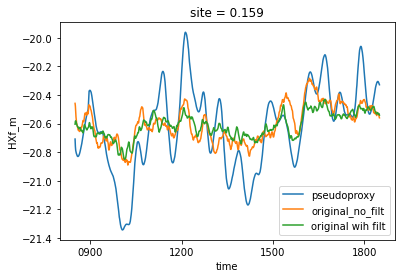

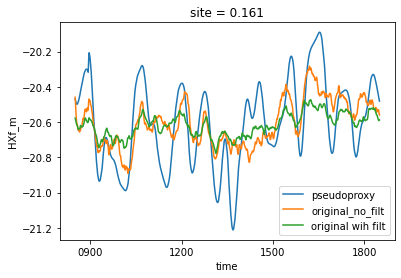

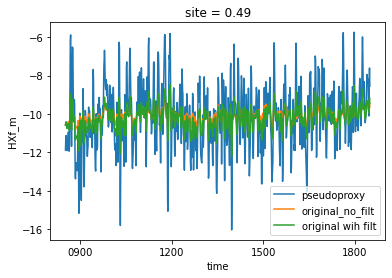

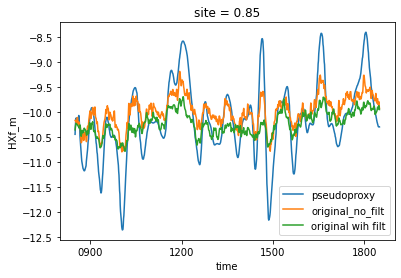

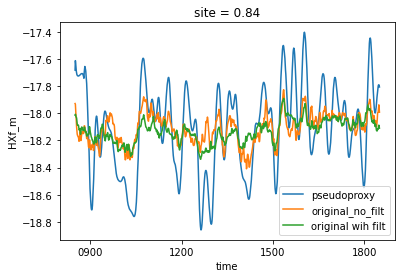

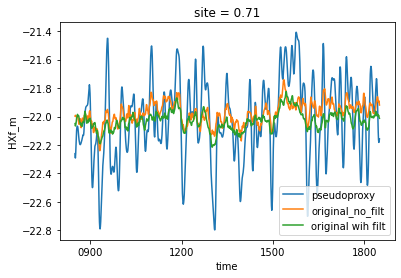

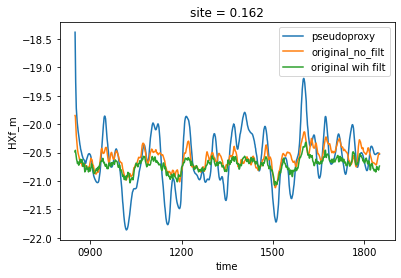

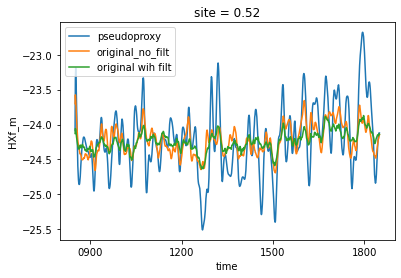

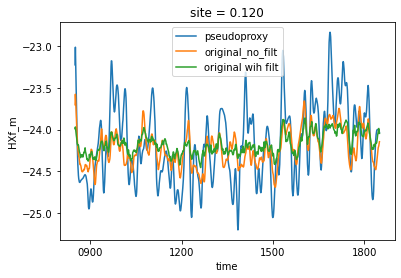

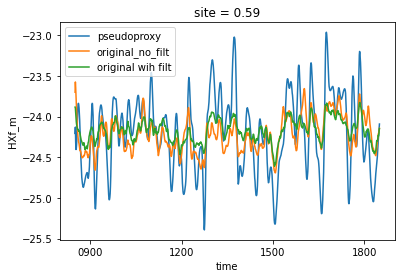

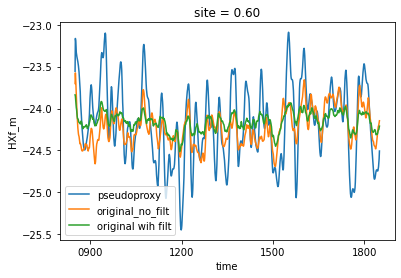

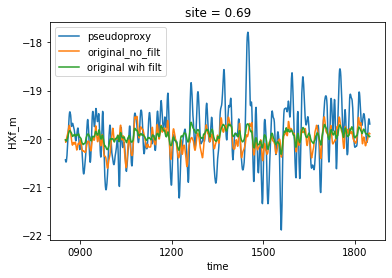

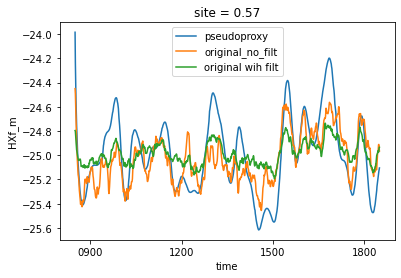

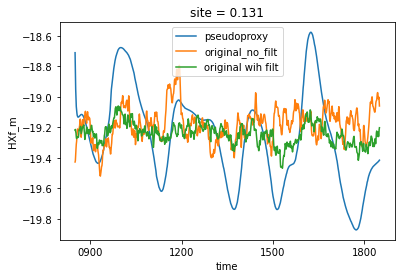

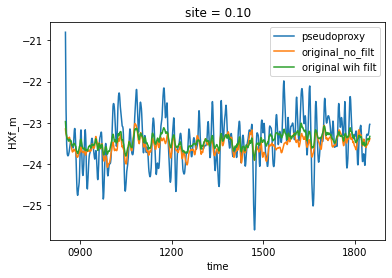

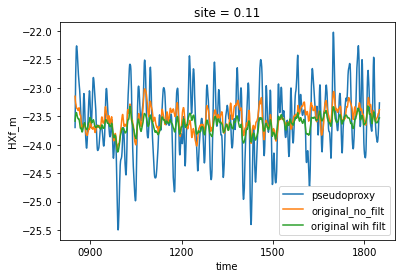

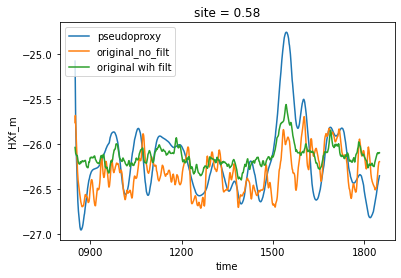

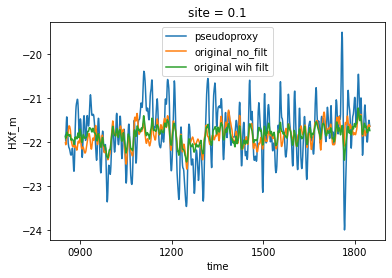

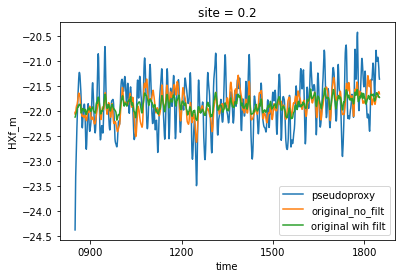

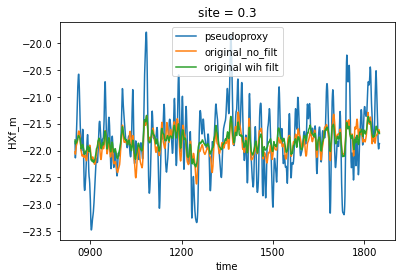

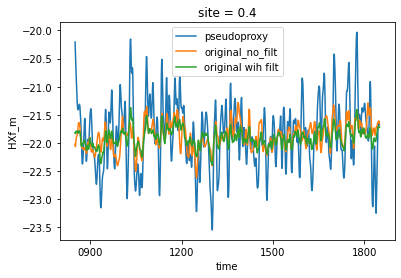

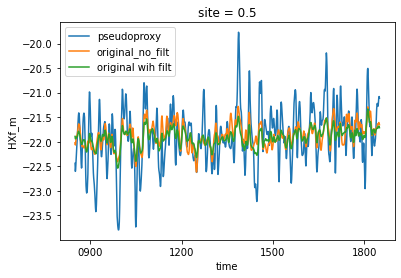

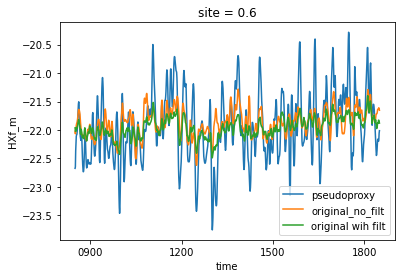

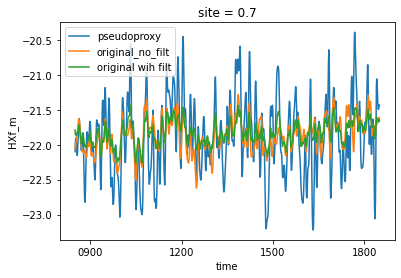

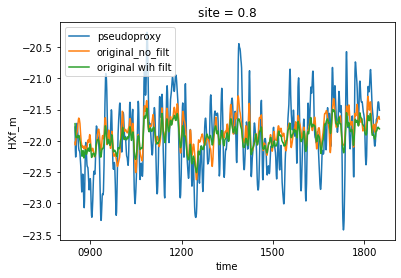

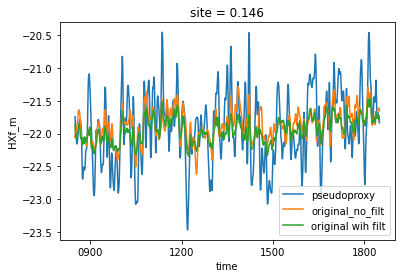

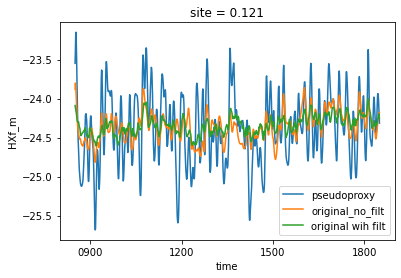

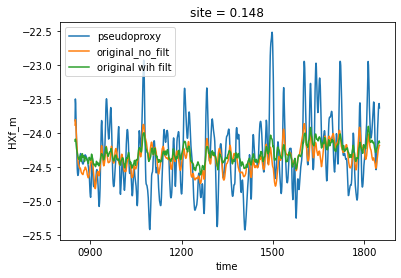

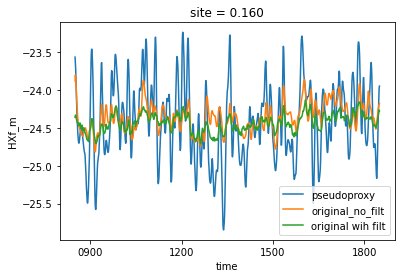

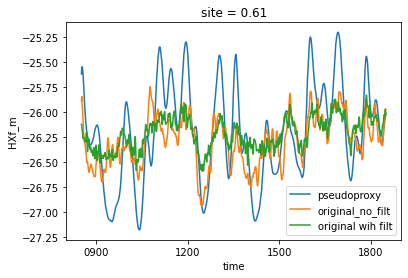

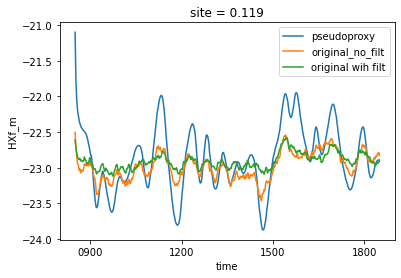

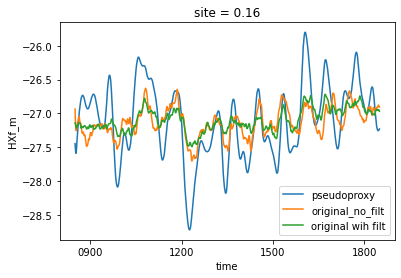

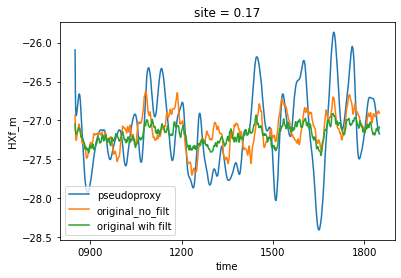

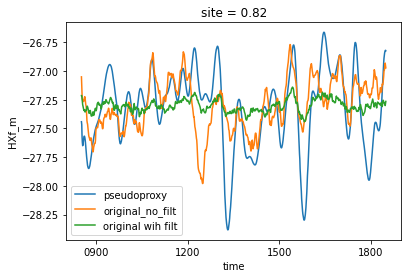

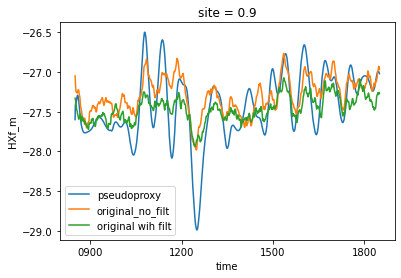

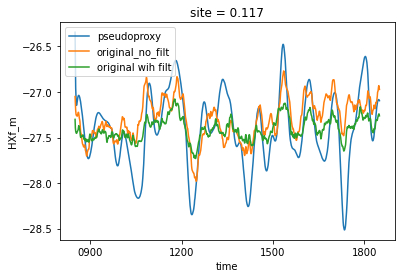

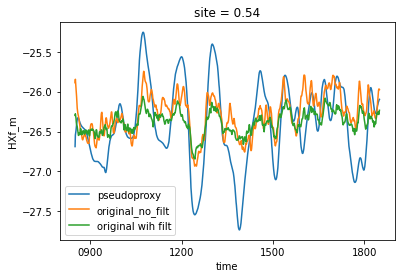

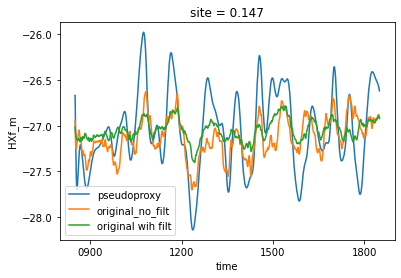

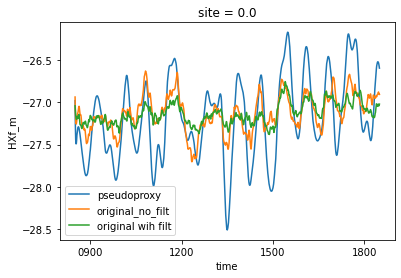

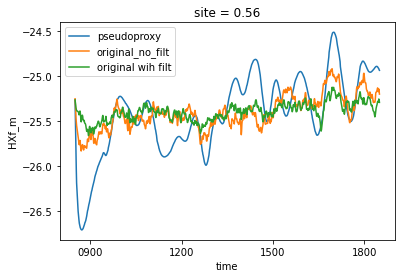

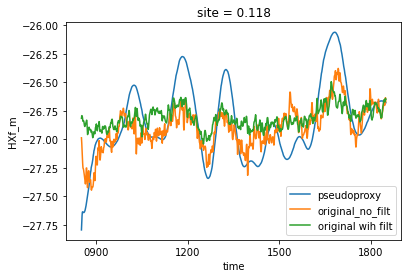

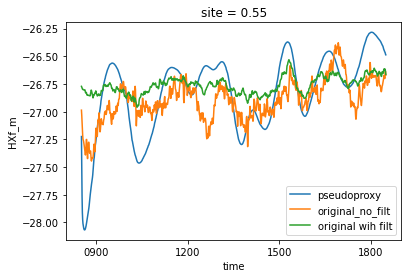

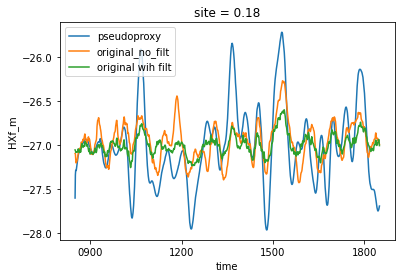

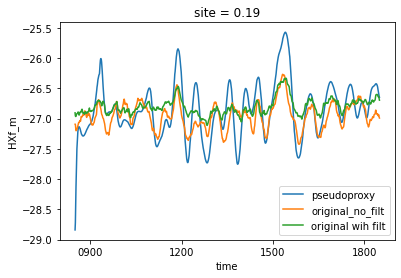

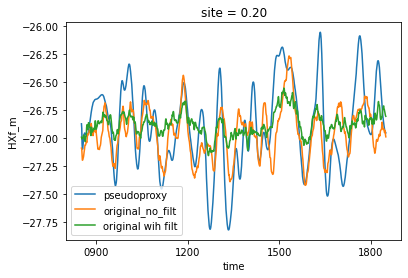

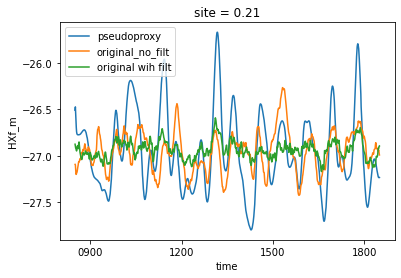

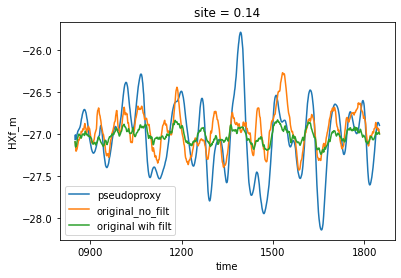

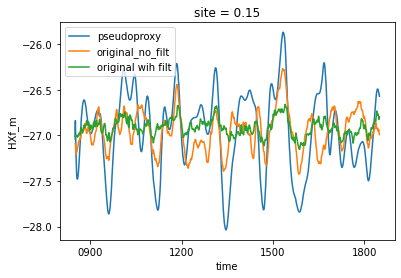

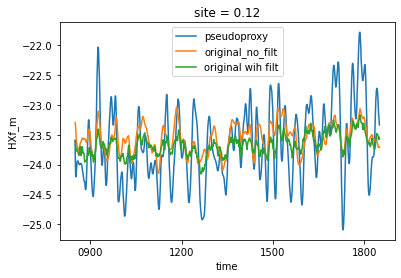

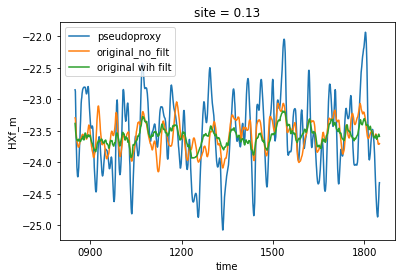

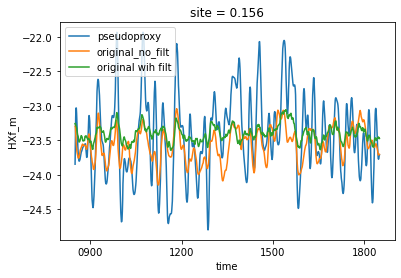

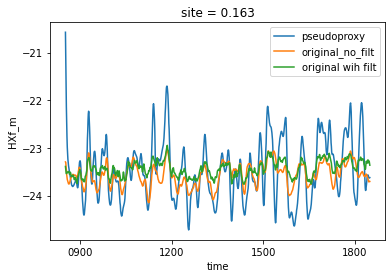

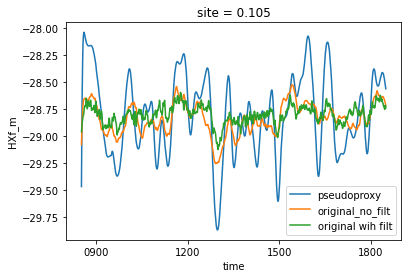

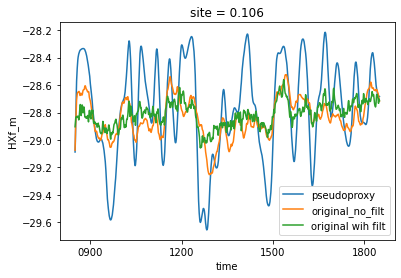

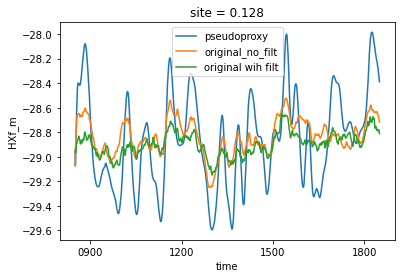

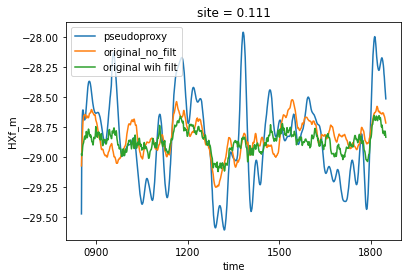

In [24]:
for i in original.site:
    proxies.sel(site_1=i).plot(label='pseudoproxy')
    data2['HXf_m'].sel(site=i).plot(label='original_no_filt')
    original.sel(site=i).plot(label='original wih filt')
    plt.legend()
    plt.show()